# 1. EDA

In [3]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/content/drive/MyDrive/train.csv')
df

,u,v,t,h
0,3248374,11431799,27,6
1,3429130,4795235,13,8
2,105512,8910840,74,2
3,7900466,9739979,36,9
4,7296485,9838285,52,2
...,...,...,...,...
17414505,4094488,6047565,60,0
17414506,5145645,9438946,71,0
17414507,3091848,5510632,67,0
17414508,10314756,10497610,49,0


In [ ]:
from tqdm.auto import trange

id2pos = {}
N = 0
for i in trange(df.shape[0]):
    if df['u'].iloc[i] not in id2pos.keys():
        id2pos[df['u'].iloc[i]] = N 
        N += 1
    if df['v'].iloc[i] not in id2pos.keys():
        id2pos[df['v'].iloc[i]] = N 
        N += 1


In [7]:
df['u'] = df['u'].apply(lambda x: id2pos[x])
df['v'] = df['v'].apply(lambda x: id2pos[x])

In [8]:
df.to_csv('/content/drive/MyDrive/train_mod.csv')

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/content/drive/MyDrive/train_mod.csv')
df

,Unnamed: 0,u,v,t,h
0,0,0,1,27,6
1,1,2,3,13,8
2,2,4,5,74,2
3,3,6,7,36,9
4,4,8,9,52,2
...,...,...,...,...,...
17414505,17414505,67072,94867,60,0
17414506,17414506,991066,1279987,71,0
17414507,17414507,125201,68549,67,0
17414508,17414508,27914,3234444,49,0


## 1.1 Проверка на ориентированность

In [9]:
edges_set = set()
for i in range(df.shape[0]):
    edges_set.add((df['u'].iloc[i], df['v'].iloc[i]))

bidirectional=True
for u, v in edges_set:
    if (v, u) not in edges_set:
        bidirectional = False
        break

print("Graph is bidirectional" if bidirectional else "Graph is not bidirectional")

Graph is not bidirectional


In [10]:
del edges_set

## 1.2 Распределение h

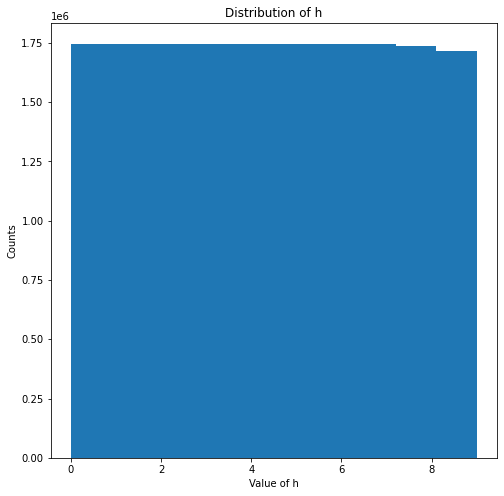

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 8))
plt.hist(df['h'])
plt.xlabel("Value of h")
plt.ylabel("Counts")
plt.title("Distribution of h")
plt.show()

## 1.3 Распеределение t

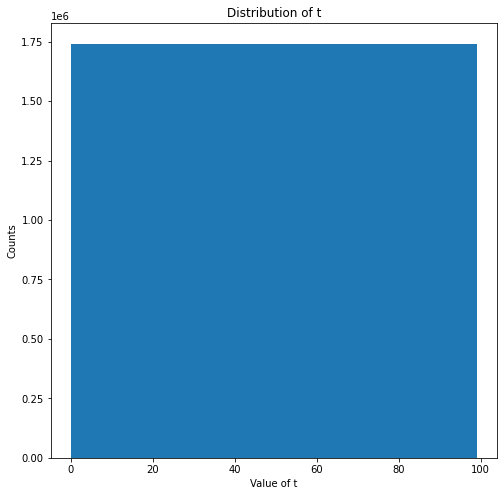

In [12]:
plt.figure(figsize=(8, 8))
plt.hist(df['t'])
plt.xlabel("Value of t")
plt.ylabel("Counts")
plt.title("Distribution of t")
plt.show()

## 1.3 Степени вершин

In [13]:
N = max(df['u'].max(), df['v'].max())
print(f"Maximal id of node is: {N}")

degrees = np.zeros(N + 1)
for u in df['u'].values:
    degrees[u] += 1
for u in df['v'].values:
    degrees[u] += 1

Maximal id of node is: 3234444


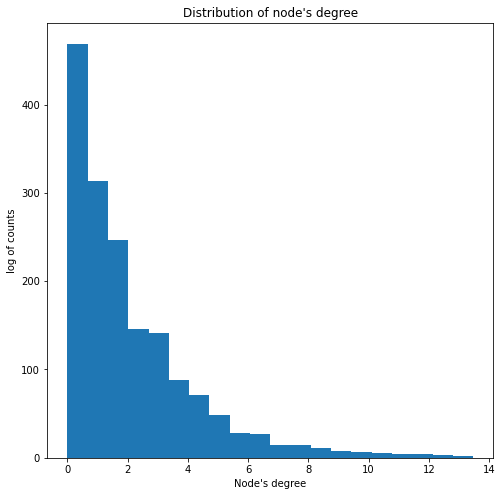

In [14]:
uniq, counts = np.unique(degrees[degrees > 0], return_counts=True)

plt.figure(figsize=(8, 8))
plt.hist(np.log(counts), bins=20)
plt.xlabel("Node's degree")
plt.ylabel("log of counts")
plt.title("Distribution of node's degree")
plt.show()

In [27]:
np.mean(degrees)

10.768159606980486

## 1.4 Компоненты связаности

In [16]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import networkx as nx
G = nx.Graph()

G.add_nodes_from(df['u'].values)
G.add_nodes_from(df['v'].values)

G.add_edges_from(df[['u', 'v']].values)


In [17]:
nx.number_connected_components(G)


31188

In [18]:
sizes_comp = [len(c) for c in nx.connected_components(G)]

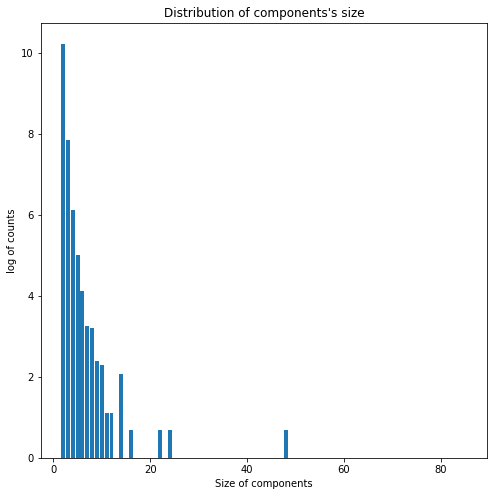

In [19]:
import matplotlib.pyplot as plt

uniq, counts = np.unique(sizes_comp, return_counts=True)


plt.figure(figsize=(8, 8))
plt.bar(uniq[:-1], np.log(counts[:-1]))
plt.xlabel("Size of components")
plt.ylabel("log of counts")
plt.title("Distribution of components's size")
plt.show()

In [20]:
uniq

array([      2,       3,       4,       5,       6,       7,       8,
             9,      10,      11,      12,      14,      15,      16,
            17,      19,      21,      22,      24,      25,      28,
            29,      31,      33,      34,      36,      42,      48,
            65,      77,      85, 3166590])

In [21]:
counts

array([27862,  2545,   459,   151,    61,    26,    25,    11,    10,
           3,     3,     8,     1,     2,     1,     1,     1,     2,
           2,     1,     1,     1,     1,     1,     1,     1,     1,
           2,     1,     1,     1,     1])

# 1.5 Распеределение центральностей

In [7]:
from scipy import sparse

N = max(df['u'].max(), df['v'].max())
I = df['u'].values
J = df['v'].values
V = np.ones_like(I)

A = sparse.coo_matrix((V,(I,J)),shape=(N+1,N+1))
A = A + A.T

In [8]:
from scipy.sparse.linalg import eigsh

A = A.asfptype()
self_numb, self_vecs = eigsh(A,  k=6)


In [9]:
self_vecs[:, -1]

array([-2.72502692e-20,  1.43681911e-20,  2.15721428e-20, ...,
        8.59708136e-20, -9.53656226e-20, -4.86659220e-07])

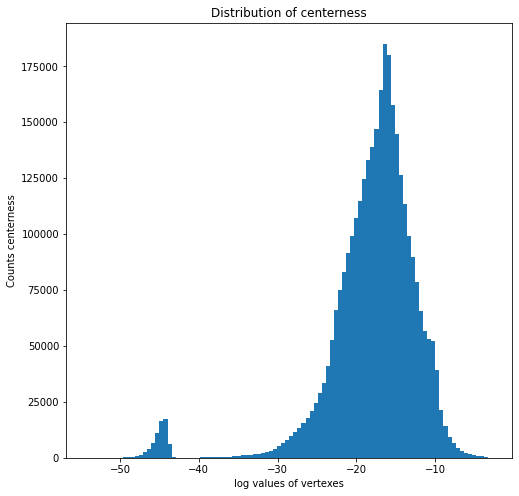

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.hist(np.log(np.abs(self_vecs[:, -1])), bins=100)
plt.xlabel("log values of vertexes")
plt.ylabel("Counts centerness")
plt.title("Distribution of centerness")
plt.show()

## 1.6 Корреляция между степенью вершины и ее центральностью

In [4]:
N = max(df['u'].max(), df['v'].max())

degrees = np.zeros(N + 1)
for u in df['u'].values:
    degrees[u] += 1
for u in df['v'].values:
    degrees[u] += 1

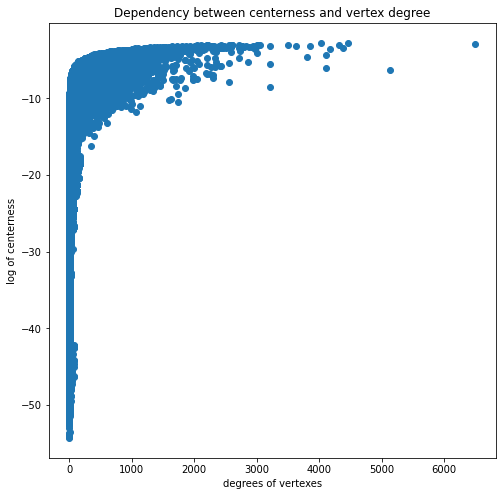

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter(degrees, np.log(np.abs(self_vecs[:, -1])))
plt.xlabel("degrees of vertexes")
plt.ylabel("log of centerness")
plt.title("Dependency between centerness and vertex degree")
plt.show()

## 1.7 Коэффициент кластеризации

In [ ]:
cluster_coef = nx.clustering(G)
cluster_coef

In [20]:
cluster_coefs = np.zeros(N + 1)

for key, value in cluster_coef.items():
    cluster_coefs[int(key)] = value

In [24]:
np.save('/content/drive/MyDrive/cluster_coef.pt', cluster_coefs)

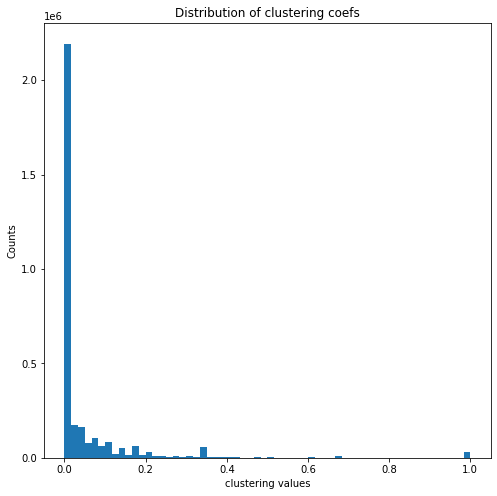

In [26]:
plt.figure(figsize=(8, 8))
plt.hist(cluster_coefs, bins=60)
plt.xlabel("clustering values")
plt.ylabel("Counts")
plt.title("Distribution of clustering coefs")
plt.show()

## 1.8 Корреляция между степенью вершины и кластеризуемостью

In [3]:
cluster_coefs = np.load('/content/drive/MyDrive/cluster_coef.pt.npy')

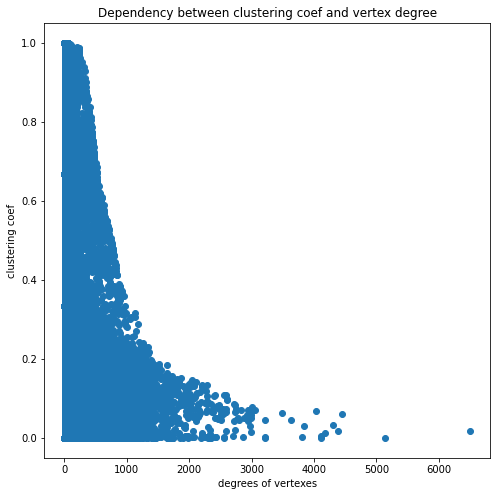

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(degrees, cluster_coefs)
plt.xlabel("degrees of vertexes")
plt.ylabel("clustering coef")
plt.title("Dependency between clustering coef and vertex degree")
plt.show()

## 1.9 Корреляция между кластеризуемостью и центральностью

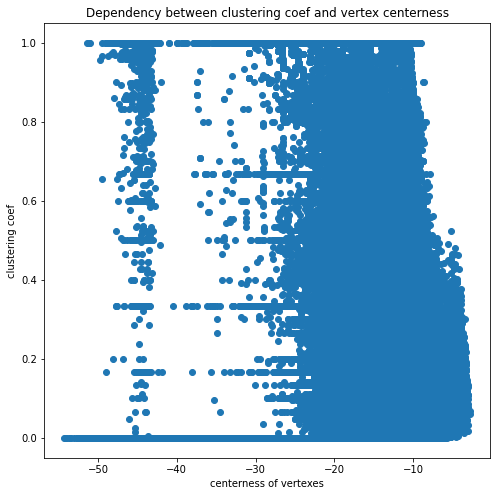

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(np.log(np.abs(self_vecs[:, -1])), cluster_coefs)
plt.xlabel("centerness of vertexes")
plt.ylabel("clustering coef")
plt.title("Dependency between clustering coef and vertex centerness")
plt.show()

## 1.10 Распеределение h в зависимости от степени центральности и степени вершины 

Зависимость от степени

In [ ]:
from tqdm.auto import trange

mean_deg = []
hs = df['h'].values

for i in trange(df.shape[0]):
    mean_deg.append((degrees[df['u'].iloc[i]] +  degrees[df['v'].iloc[i]]) / 2)


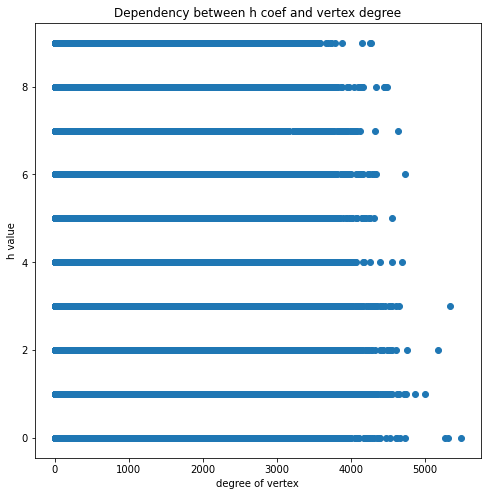

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_deg, hs)
plt.xlabel("degree of vertex")
plt.ylabel("h value")
plt.title("Dependency between h coef and vertex degree")
plt.show()

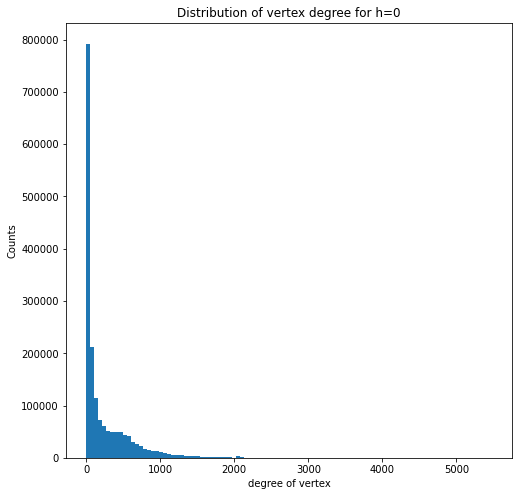

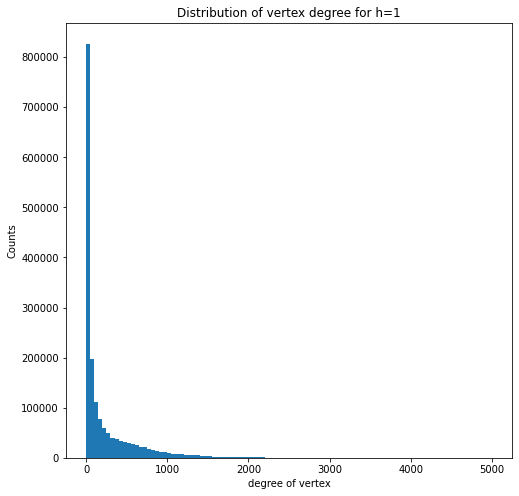

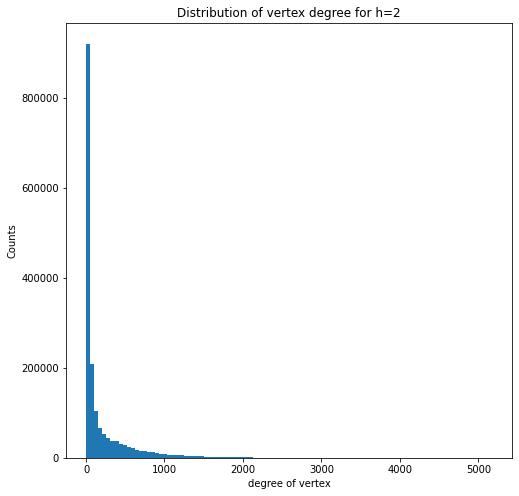

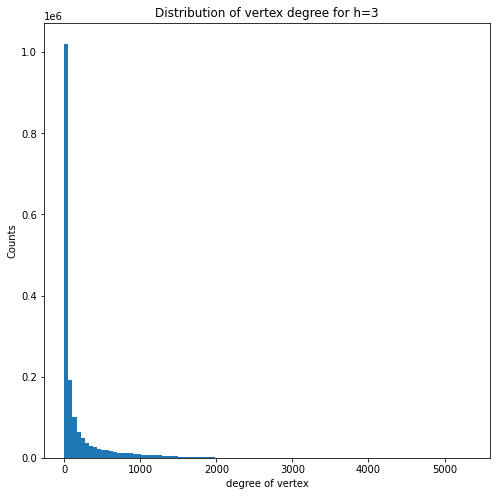

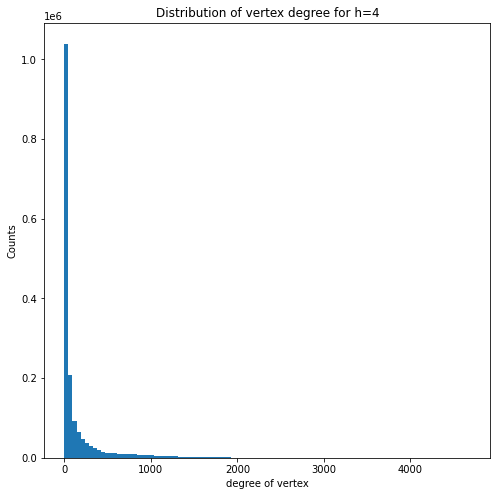

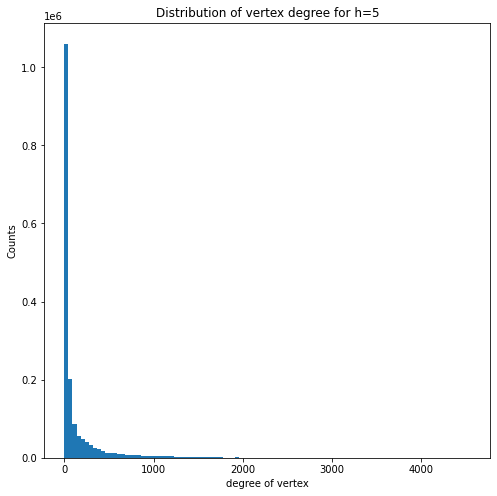

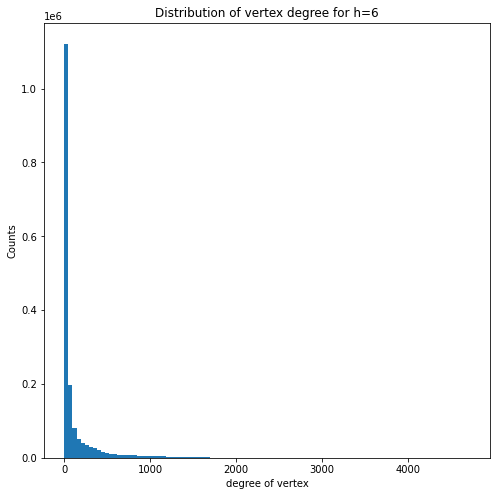

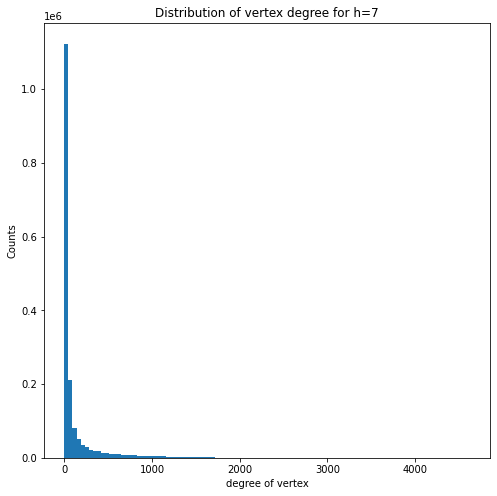

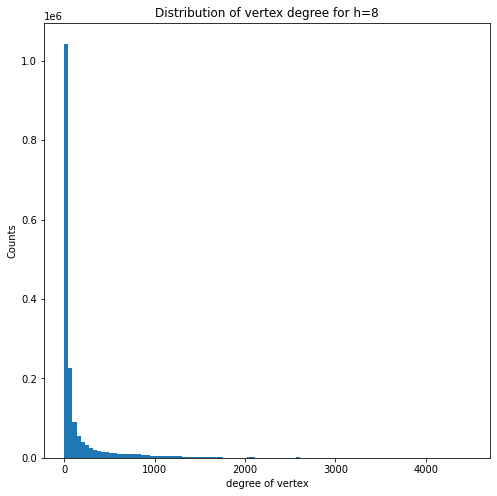

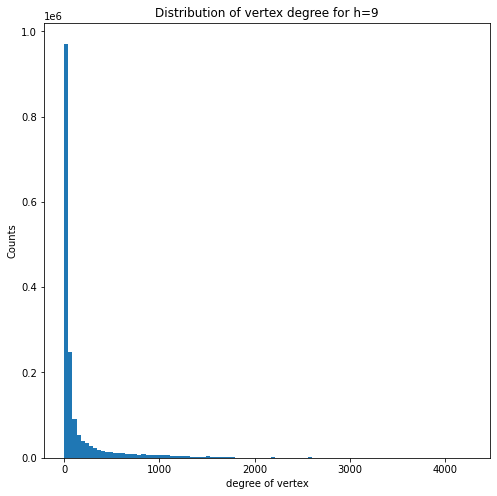

In [19]:
mean_deg = np.array(mean_deg)

for h_i in np.unique(hs):
    degs_cur = mean_deg[hs == h_i]

    plt.figure(figsize=(8, 8))
    plt.hist(degs_cur, bins=100)
    plt.xlabel("degree of vertex")
    plt.ylabel("Counts")
    plt.title(f"Distribution of vertex degree for h={h_i}")
    plt.show()

Зависимость от центральности:

In [20]:
centerness_coefs = np.log(np.abs(self_vecs[:, -1]))

mean_centerness = []
hs = df['h'].values

for i in trange(df.shape[0]):
    mean_centerness.append((centerness_coefs[df['u'].iloc[i]] +  centerness_coefs[df['v'].iloc[i]]) / 2)


  0%|          | 0/17414510 [00:00<?, ?it/s]

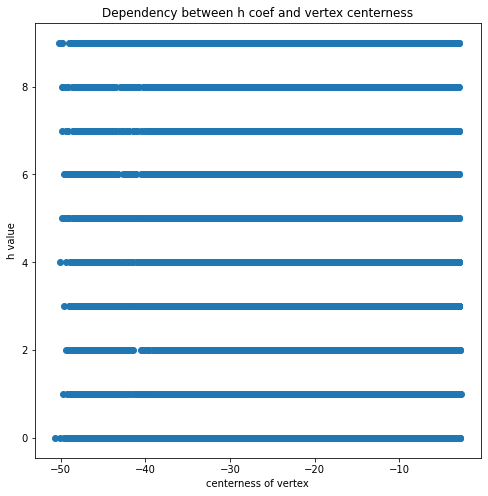

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_centerness, hs)
plt.xlabel("centerness of vertex")
plt.ylabel("h value")
plt.title("Dependency between h coef and vertex centerness")
plt.show()

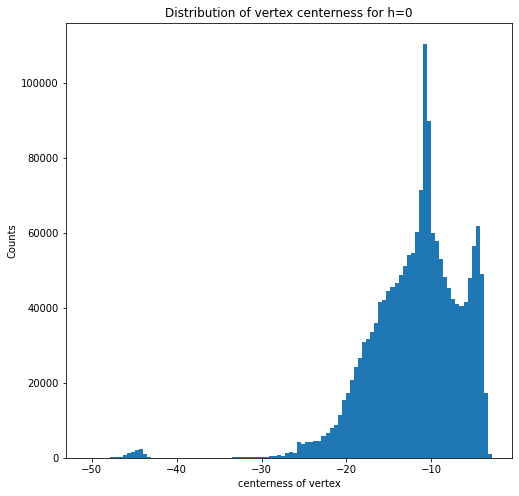

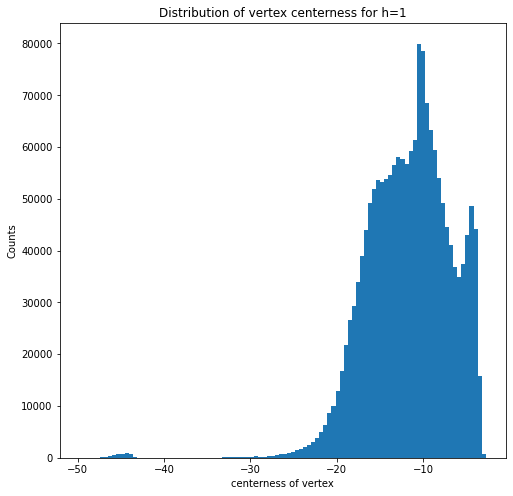

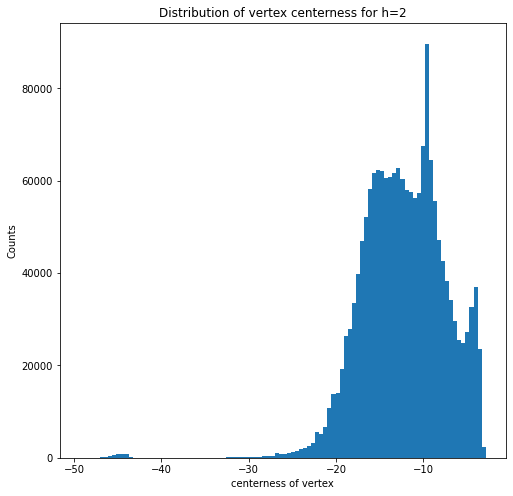

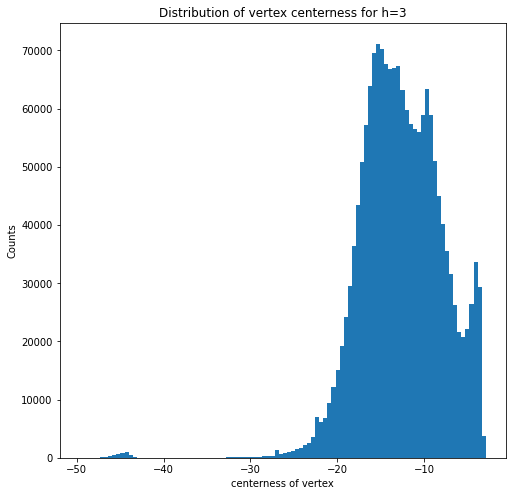

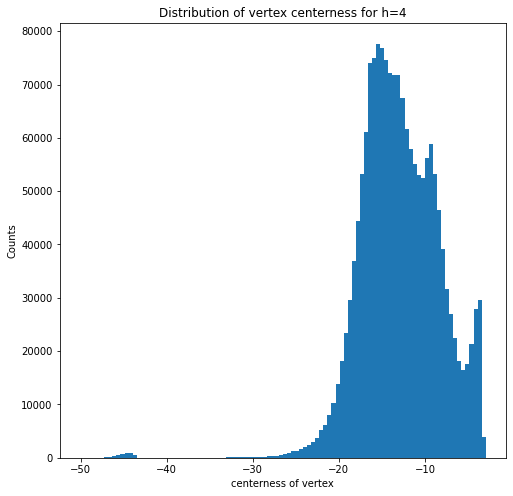

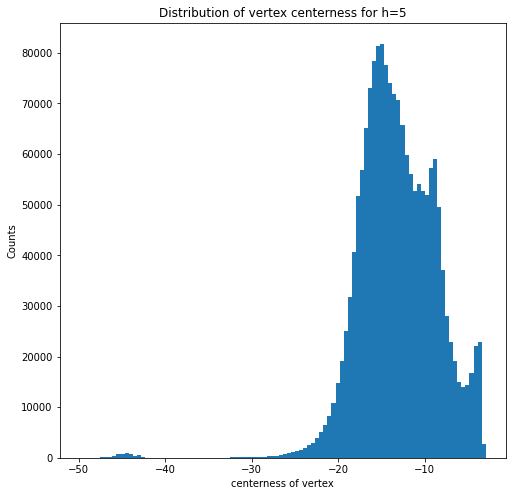

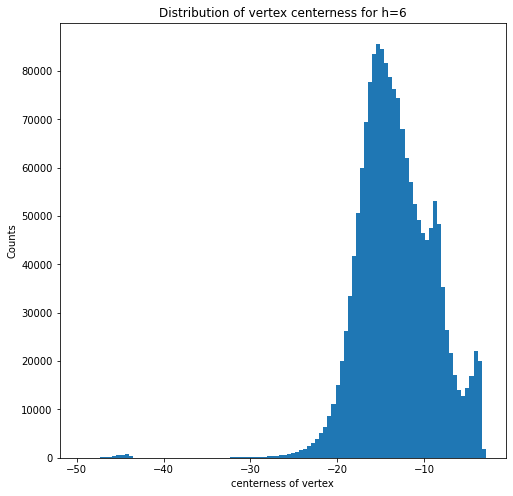

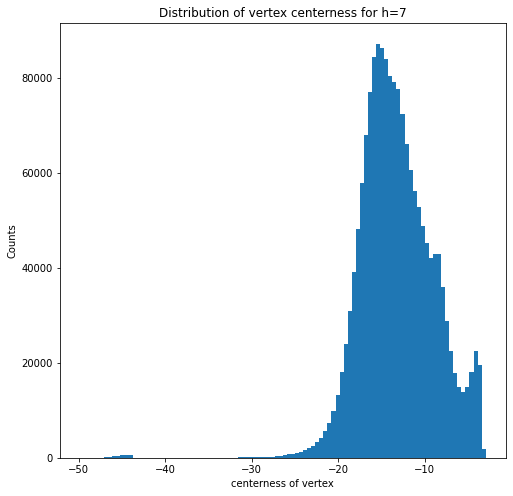

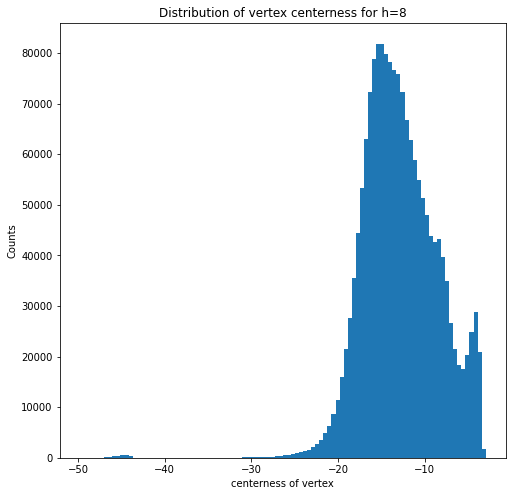

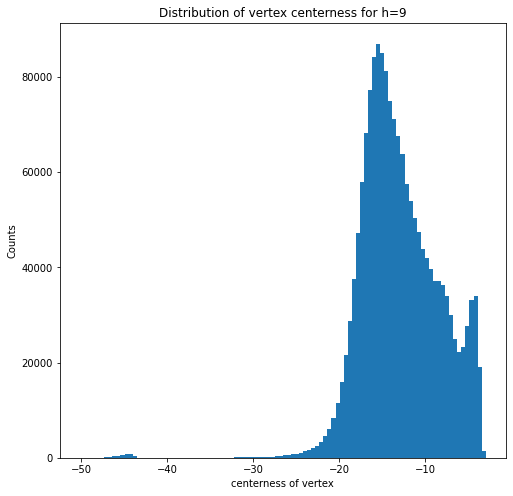

In [23]:
mean_centerness = np.array(mean_centerness)

for h_i in np.unique(hs):
    degs_cur = mean_centerness[hs == h_i]

    plt.figure(figsize=(8, 8))
    plt.hist(degs_cur, bins=100)
    plt.xlabel("centerness of vertex")
    plt.ylabel("Counts")
    plt.title(f"Distribution of vertex centerness for h={h_i}")
    plt.show()

## 1.11 Распеределение t в зависимости от центральности и степени вершины

В зависимости от степени:

In [24]:
ts = df['t'].values


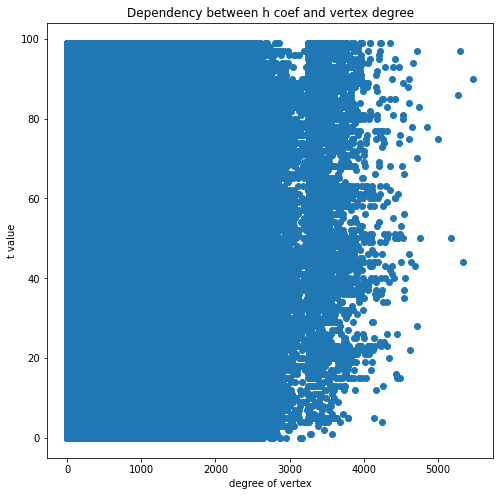

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_deg, ts)
plt.xlabel("degree of vertex")
plt.ylabel("t value")
plt.title("Dependency between t coef and vertex degree")
plt.show()

В зависимости от центральности:

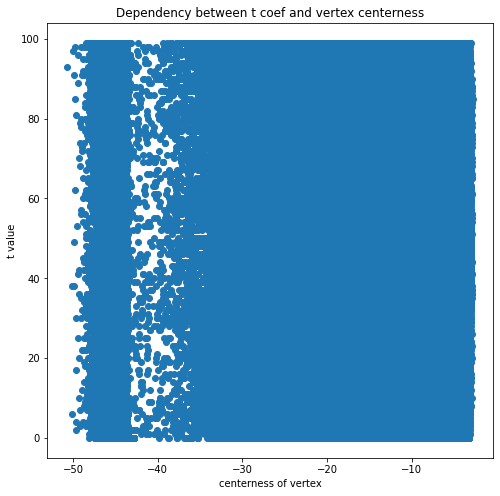

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_centerness, ts)
plt.xlabel("centerness of vertex")
plt.ylabel("t value")
plt.title("Dependency between t coef and vertex centerness")
plt.show()

## 1.12 Визуализация подграфов

In [32]:
import networkx as nx
G = nx.Graph()

G.add_nodes_from(df['u'].values)
G.add_nodes_from(df['v'].values)

G.add_edges_from(df[['u', 'v']].values)


Подграфы с радиусом 2

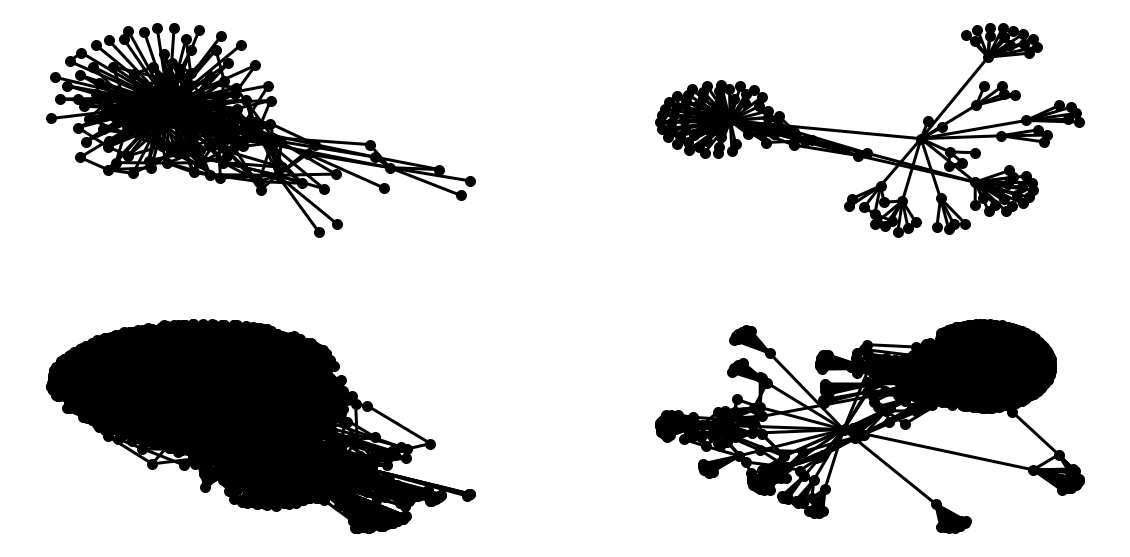

In [15]:
from networkx import ego_graph
from random import randint
import matplotlib.pyplot as plt

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

N = max(df['u'].max(), df['v'].max())
plt.figure(figsize=(20, 10))

subax1 = plt.subplot(221)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax2 = plt.subplot(222)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax3 = plt.subplot(223)

v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax4 = plt.subplot(224)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)


Подграфы с радиусом 1

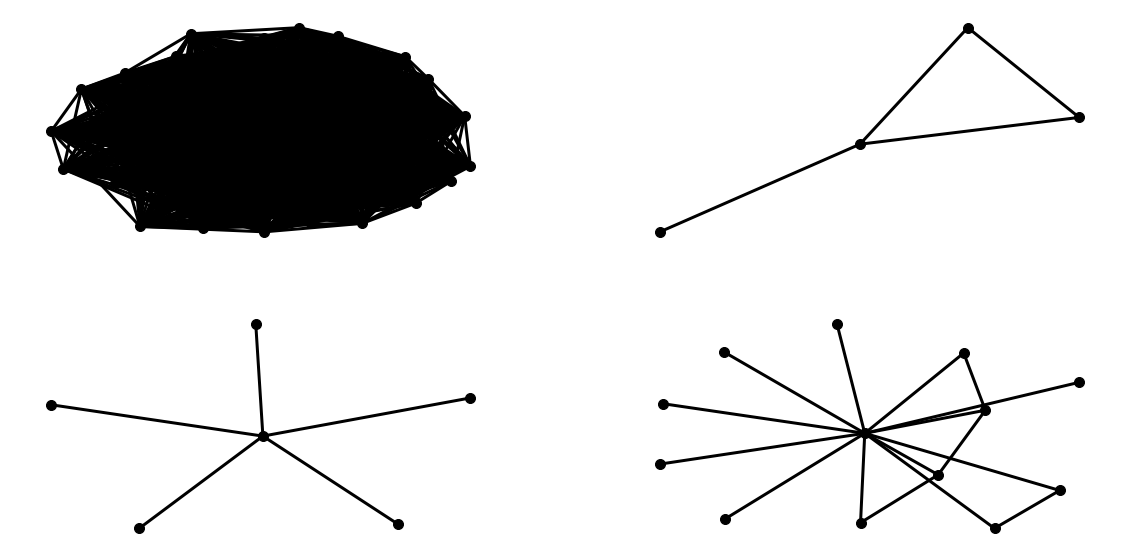

In [16]:
from networkx import ego_graph
from random import randint
import matplotlib.pyplot as plt

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

N = max(df['u'].max(), df['v'].max())
plt.figure(figsize=(20, 10))

subax1 = plt.subplot(221)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=1)
nx.draw(g0, **options)

subax2 = plt.subplot(222)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=1)
nx.draw(g0, **options)

subax3 = plt.subplot(223)

v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=1)
nx.draw(g0, **options)

subax4 = plt.subplot(224)
v0 = 0
while v0 not in df['u'].values and v0 not in df['v'].values:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=1)
nx.draw(g0, **options)


Менее центральный подграф:

In [56]:
mask_center = ((centerness_coefs < -35))

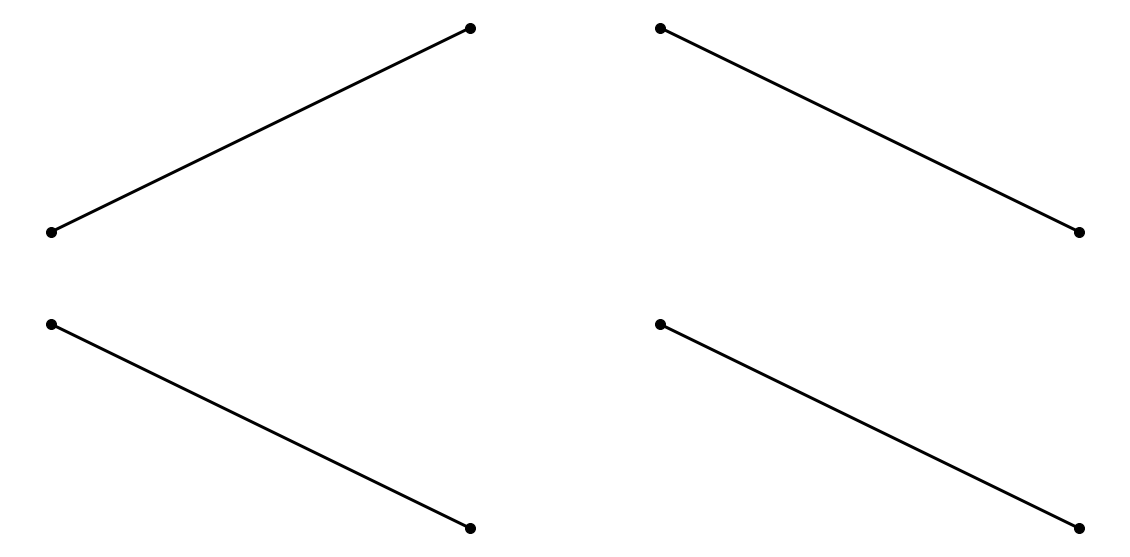

In [57]:
from networkx import ego_graph
from random import randint
import matplotlib.pyplot as plt

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

N = max(df['u'].max(), df['v'].max())
plt.figure(figsize=(20, 10))

subax1 = plt.subplot(221)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax2 = plt.subplot(222)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax3 = plt.subplot(223)

v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax4 = plt.subplot(224)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)


Более центральный подграф:

In [60]:
mask_center = ((centerness_coefs > -15) & (centerness_coefs < -10))

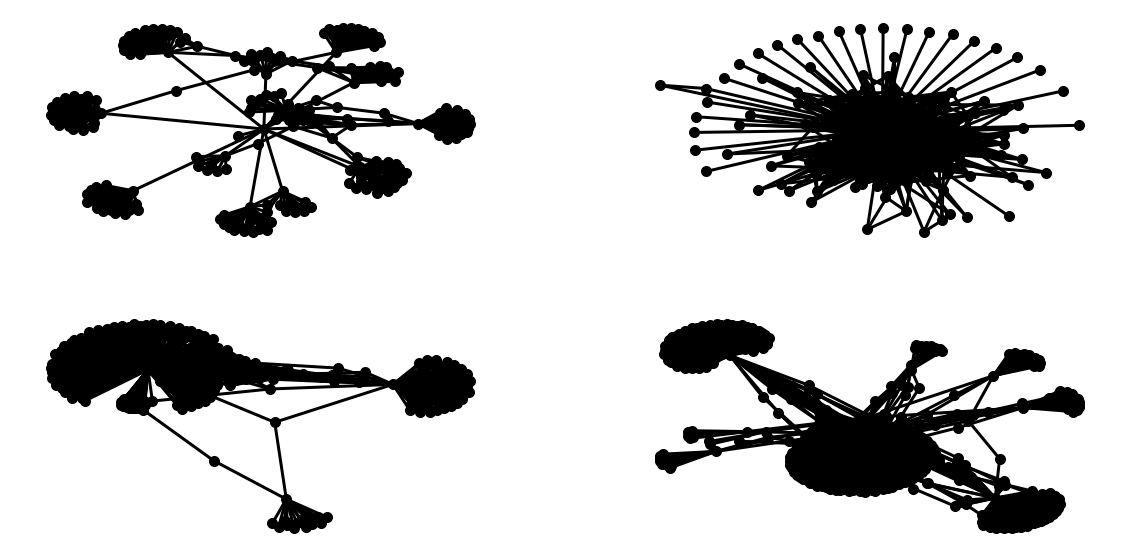

In [61]:
from networkx import ego_graph
from random import randint
import matplotlib.pyplot as plt

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}

N = max(df['u'].max(), df['v'].max())
plt.figure(figsize=(20, 10))

subax1 = plt.subplot(221)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax2 = plt.subplot(222)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax3 = plt.subplot(223)

v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)

subax4 = plt.subplot(224)
v0 = 0
while (v0 not in df['u'].values and v0 not in df['v'].values) or not mask_center[v0]:
    v0 = randint(0, N) 

g0 = ego_graph(G, n=v0, radius=2)
nx.draw(g0, **options)
